In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

BATTERY_CAPACITY_KWH = 33.0

In [15]:
# Load all trips and filter by SOC change > 5%
trip_files = sorted(glob('BMW_i3_Dataset/Trip*.csv'))
print(f"Total trip files: {len(trip_files)}")

valid_trips = []
for trip_file in trip_files:
    df = pd.read_csv(trip_file, sep=';', encoding='latin-1')
    soc_change = df['SoC [%]'].iloc[0] - df['SoC [%]'].iloc[-1]
    
    if soc_change > 5:  # Only trips with >5% SOC change
        trip_name = trip_file.split('\\')[-1]
        valid_trips.append((trip_name, df, soc_change))

print(f"Valid trips (SOC change > 5%): {len(valid_trips)}")

Total trip files: 70
Valid trips (SOC change > 5%): 39


In [16]:
# Create training samples: predict energy consumption rate (Wh/km) from driving conditions
segments = []
WINDOW_SIZE = 100
MIN_VELOCITY = 5.0

for trip_name, df, _ in valid_trips:
    col_map = {}
    for pattern in ['Battery Voltage', 'Battery Current', 'Battery Temperature', 
                    'Ambient Temperature', 'Velocity', 'Elevation', 'SoC']:
        matching = [col for col in df.columns if pattern in col and 
                   'displayed' not in col and 'min' not in col and 'max' not in col]
        if matching:
            col_map[pattern] = matching[0]
    
    df_moving = df[df[col_map['Velocity']] > MIN_VELOCITY].copy().reset_index(drop=True)
    
    if len(df_moving) < WINDOW_SIZE * 2:
        continue
    
    df_moving['Power_W'] = df_moving[col_map['Battery Voltage']] * abs(df_moving[col_map['Battery Current']])
    df_moving['Distance_km'] = (df_moving[col_map['Velocity']] / 3600) * 0.1
    df_moving['Energy_Wh'] = (df_moving['Power_W'] / 3600) * 0.1
    
    for i in range(0, len(df_moving) - WINDOW_SIZE, WINDOW_SIZE // 2):
        window = df_moving.iloc[i:i+WINDOW_SIZE]
        
        total_energy = window['Energy_Wh'].sum()
        total_distance = window['Distance_km'].sum()
        
        if total_distance < 0.01:
            continue
        
        consumption_rate = total_energy / total_distance
        
        segment = {
            'SOC_start': window[col_map['SoC']].iloc[0],
            'SOC_avg': window[col_map['SoC']].mean(),
            'Battery_Voltage': window[col_map['Battery Voltage']].mean(),
            'Battery_Temperature': window[col_map['Battery Temperature']].mean(),
            'Velocity_avg': window[col_map['Velocity']].mean(),
            'Velocity_std': window[col_map['Velocity']].std(),
            'Velocity_max': window[col_map['Velocity']].max(),
            'Acceleration': window[col_map['Velocity']].diff().mean(),
            'Elevation_start': window[col_map['Elevation']].iloc[0],
            'Elevation_change': window[col_map['Elevation']].iloc[-1] - window[col_map['Elevation']].iloc[0],
            'Elevation_std': window[col_map['Elevation']].std(),
            'Ambient_Temperature': window[col_map['Ambient Temperature']].mean(),
            'Temp_diff': (window[col_map['Battery Temperature']].mean() - 
                         window[col_map['Ambient Temperature']].mean()),
            'Energy_Consumption_Wh_per_km': consumption_rate,
            'Trip': trip_name
        }
        
        segments.append(segment)

data = pd.DataFrame(segments)
print(f"\nTotal training segments: {len(data):,}")
print(f"\nEnergy consumption statistics (Wh/km):")
print(data['Energy_Consumption_Wh_per_km'].describe())


Total training segments: 10,624

Energy consumption statistics (Wh/km):
count    10624.000000
mean       248.252940
std        178.859698
min          9.289986
25%        131.599350
50%        201.022829
75%        317.437656
max       1869.350033
Name: Energy_Consumption_Wh_per_km, dtype: float64


In [17]:
# Remove outliers
Q1 = data['Energy_Consumption_Wh_per_km'].quantile(0.01)
Q3 = data['Energy_Consumption_Wh_per_km'].quantile(0.99)
data_clean = data[(data['Energy_Consumption_Wh_per_km'] >= Q1) & 
                  (data['Energy_Consumption_Wh_per_km'] <= Q3)].copy()

print(f"After outlier removal: {len(data_clean):,} segments")
print(f"Consumption range: {data_clean['Energy_Consumption_Wh_per_km'].min():.1f} to {data_clean['Energy_Consumption_Wh_per_km'].max():.1f} Wh/km")

data_clean = data_clean.dropna()
print(f"After removing NaN: {len(data_clean):,} segments")

After outlier removal: 10,410 segments
Consumption range: 38.5 to 848.3 Wh/km
After removing NaN: 10,410 segments


In [18]:
feature_cols = ['SOC_start', 'SOC_avg', 'Battery_Voltage', 'Battery_Temperature',
                'Velocity_avg', 'Velocity_std', 'Velocity_max', 'Acceleration',
                'Elevation_start', 'Elevation_change', 'Elevation_std',
                'Ambient_Temperature', 'Temp_diff']

correlations = data_clean[feature_cols + ['Energy_Consumption_Wh_per_km']].corr()['Energy_Consumption_Wh_per_km'].drop('Energy_Consumption_Wh_per_km')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("\nFeature correlations with energy consumption:")
for feat, corr in correlations_sorted.head(10).items():
    actual_corr = correlations[feat]
    print(f"  {feat:30s}: {actual_corr:+.4f}")


Feature correlations with energy consumption:
  Velocity_std                  : +0.6901
  Acceleration                  : +0.4280
  Velocity_avg                  : -0.2851
  Velocity_max                  : -0.1614
  SOC_start                     : +0.0827
  SOC_avg                       : +0.0810
  Battery_Voltage               : -0.0660
  Battery_Temperature           : -0.0633
  Elevation_std                 : +0.0543
  Ambient_Temperature           : -0.0460


In [19]:
# Split by trip to avoid data leakage
unique_trips = data_clean['Trip'].unique()
train_trips, test_trips = train_test_split(unique_trips, test_size=0.2, random_state=42)

train_data = data_clean[data_clean['Trip'].isin(train_trips)]
test_data = data_clean[data_clean['Trip'].isin(test_trips)]

print(f"Training trips: {len(train_trips)}, samples: {len(train_data):,}")
print(f"Testing trips: {len(test_trips)}, samples: {len(test_data):,}")

X_train = train_data[feature_cols]
y_train = train_data['Energy_Consumption_Wh_per_km']
X_test = test_data[feature_cols]
y_test = test_data['Energy_Consumption_Wh_per_km']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training trips: 31, samples: 8,170
Testing trips: 8, samples: 2,240


In [20]:
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

print("\n=== Random Forest Results ===")
print(f"Training R²: {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"Testing R²: {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f} Wh/km")
print(f"Testing MAE: {mean_absolute_error(y_test, y_test_pred_rf):.2f} Wh/km")

Training Random Forest...

=== Random Forest Results ===
Training R²: 0.8973
Testing R²: 0.8255
Testing RMSE: 61.48 Wh/km
Testing MAE: 44.47 Wh/km


In [21]:
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

y_train_pred_gb = gb_model.predict(X_train_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)

print("\n=== Gradient Boosting Results ===")
print(f"Training R²: {r2_score(y_train, y_train_pred_gb):.4f}")
print(f"Testing R²: {r2_score(y_test, y_test_pred_gb):.4f}")
print(f"Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_gb)):.2f} Wh/km")
print(f"Testing MAE: {mean_absolute_error(y_test, y_test_pred_gb):.2f} Wh/km")

Training Gradient Boosting...

=== Gradient Boosting Results ===
Training R²: 0.9713
Testing R²: 0.8355
Testing RMSE: 59.69 Wh/km
Testing MAE: 44.80 Wh/km



Feature Importance Comparison:
                Feature  RF_Importance  GB_Importance
5          Velocity_std       0.558544       0.515622
7          Acceleration       0.293747       0.271863
4          Velocity_avg       0.055606       0.064432
2       Battery_Voltage       0.017444       0.028428
6          Velocity_max       0.017082       0.029626
9      Elevation_change       0.010851       0.012916
10        Elevation_std       0.007838       0.009193
8       Elevation_start       0.007588       0.014723
1               SOC_avg       0.006713       0.014693
11  Ambient_Temperature       0.006566       0.010399
0             SOC_start       0.006519       0.011381
3   Battery_Temperature       0.005896       0.008155
12            Temp_diff       0.005607       0.008569


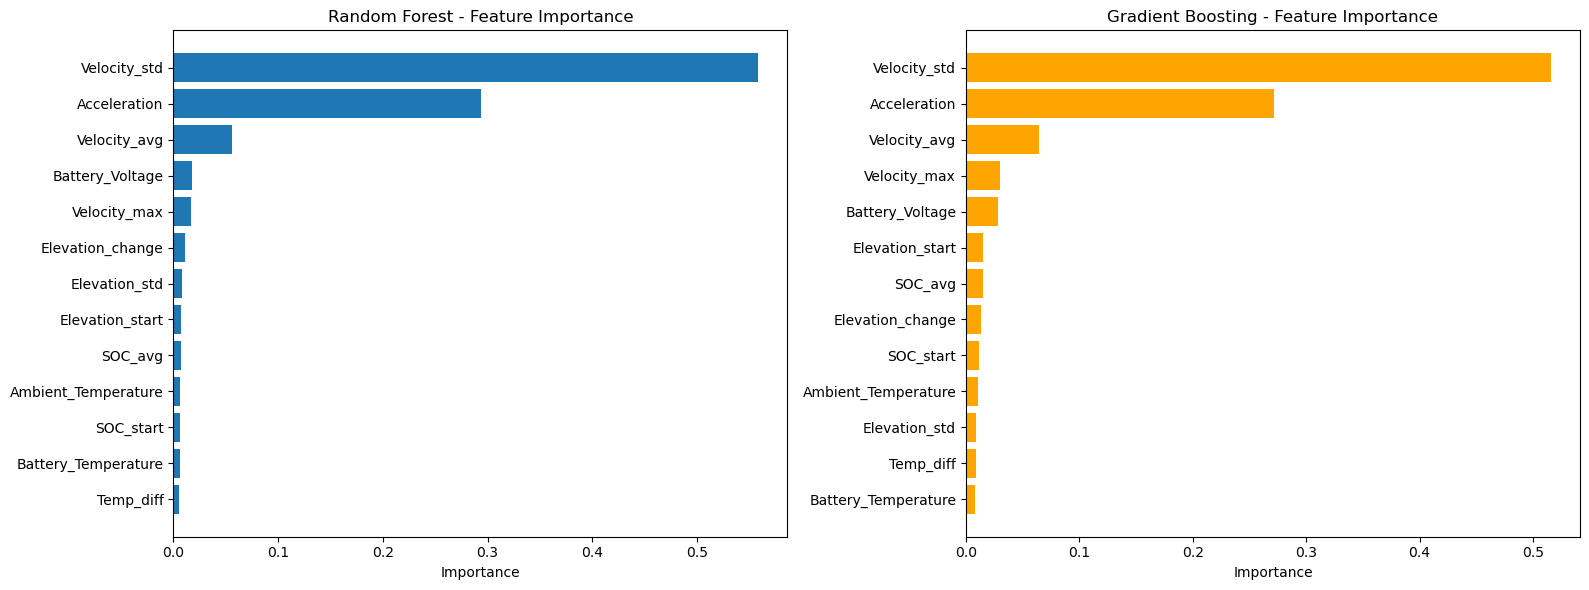

In [22]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_model.feature_importances_,
    'GB_Importance': gb_model.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\nFeature Importance Comparison:")
print(feature_importance)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(feature_importance['Feature'], feature_importance['RF_Importance'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].invert_yaxis()

axes[1].barh(feature_importance.sort_values('GB_Importance', ascending=False)['Feature'], 
             feature_importance.sort_values('GB_Importance', ascending=False)['GB_Importance'], 
             color='orange')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [23]:
def estimate_range(current_soc, driving_conditions, model=rf_model, scaler=scaler):
    remaining_capacity_kwh = (current_soc / 100.0) * BATTERY_CAPACITY_KWH
    remaining_capacity_wh = remaining_capacity_kwh * 1000
    
    features = pd.DataFrame([driving_conditions])[feature_cols]
    features_scaled = scaler.transform(features)
    consumption_wh_per_km = model.predict(features_scaled)[0]
    
    estimated_range_km = remaining_capacity_wh / consumption_wh_per_km
    
    avg_velocity = driving_conditions.get('Velocity_avg', 50)
    estimated_time_hours = estimated_range_km / avg_velocity
    
    return estimated_range_km, estimated_time_hours, consumption_wh_per_km

print("Range estimation function created!")

Range estimation function created!


In [24]:
city_conditions = {
    'SOC_start': 50.0, 'SOC_avg': 50.0, 'Battery_Voltage': 350.0, 'Battery_Temperature': 25.0,
    'Velocity_avg': 40.0, 'Velocity_std': 15.0, 'Velocity_max': 60.0, 'Acceleration': 0.5,
    'Elevation_start': 300.0, 'Elevation_change': 5.0, 'Elevation_std': 10.0,
    'Ambient_Temperature': 20.0, 'Temp_diff': 5.0
}

print("=== City Driving (50% SOC) ===")
range_km_rf, time_h_rf, consumption_rf = estimate_range(50.0, city_conditions, model=rf_model)
range_km_gb, time_h_gb, consumption_gb = estimate_range(50.0, city_conditions, model=gb_model)
print(f"Random Forest     - Consumption: {consumption_rf:.1f} Wh/km, Range: {range_km_rf:.1f} km, Time: {time_h_rf*60:.1f} min")
print(f"Gradient Boosting - Consumption: {consumption_gb:.1f} Wh/km, Range: {range_km_gb:.1f} km, Time: {time_h_gb*60:.1f} min")

highway_conditions = {
    'SOC_start': 80.0, 'SOC_avg': 80.0, 'Battery_Voltage': 360.0, 'Battery_Temperature': 30.0,
    'Velocity_avg': 100.0, 'Velocity_std': 5.0, 'Velocity_max': 110.0, 'Acceleration': 0.1,
    'Elevation_start': 300.0, 'Elevation_change': 20.0, 'Elevation_std': 15.0,
    'Ambient_Temperature': 25.0, 'Temp_diff': 5.0
}

print("\n=== Highway Driving (80% SOC) ===")
range_km_rf, time_h_rf, consumption_rf = estimate_range(80.0, highway_conditions, model=rf_model)
range_km_gb, time_h_gb, consumption_gb = estimate_range(80.0, highway_conditions, model=gb_model)
print(f"Random Forest     - Consumption: {consumption_rf:.1f} Wh/km, Range: {range_km_rf:.1f} km, Time: {time_h_rf*60:.1f} min")
print(f"Gradient Boosting - Consumption: {consumption_gb:.1f} Wh/km, Range: {range_km_gb:.1f} km, Time: {time_h_gb*60:.1f} min")

uphill_conditions = {
    'SOC_start': 30.0, 'SOC_avg': 30.0, 'Battery_Voltage': 340.0, 'Battery_Temperature': 35.0,
    'Velocity_avg': 60.0, 'Velocity_std': 10.0, 'Velocity_max': 80.0, 'Acceleration': 0.3,
    'Elevation_start': 200.0, 'Elevation_change': 50.0, 'Elevation_std': 25.0,
    'Ambient_Temperature': 15.0, 'Temp_diff': 20.0
}

print("\n=== Uphill Driving (30% SOC) ===")
range_km_rf, time_h_rf, consumption_rf = estimate_range(30.0, uphill_conditions, model=rf_model)
range_km_gb, time_h_gb, consumption_gb = estimate_range(30.0, uphill_conditions, model=gb_model)
print(f"Random Forest     - Consumption: {consumption_rf:.1f} Wh/km, Range: {range_km_rf:.1f} km, Time: {time_h_rf*60:.1f} min")
print(f"Gradient Boosting - Consumption: {consumption_gb:.1f} Wh/km, Range: {range_km_gb:.1f} km, Time: {time_h_gb*60:.1f} min")

=== City Driving (50% SOC) ===
Random Forest     - Consumption: 732.9 Wh/km, Range: 22.5 km, Time: 33.8 min
Gradient Boosting - Consumption: 748.1 Wh/km, Range: 22.1 km, Time: 33.1 min

=== Highway Driving (80% SOC) ===
Random Forest     - Consumption: 375.7 Wh/km, Range: 70.3 km, Time: 42.2 min
Gradient Boosting - Consumption: 450.7 Wh/km, Range: 58.6 km, Time: 35.1 min

=== Uphill Driving (30% SOC) ===
Random Forest     - Consumption: 544.5 Wh/km, Range: 18.2 km, Time: 18.2 min
Gradient Boosting - Consumption: 591.3 Wh/km, Range: 16.7 km, Time: 16.7 min



=== Test Trip Validation ===
Total test segments: 1384

Random Forest:
  MAE: 46.13 Wh/km
  R²: 0.8348

Gradient Boosting:
  MAE: 46.07 Wh/km
  R²: 0.8479


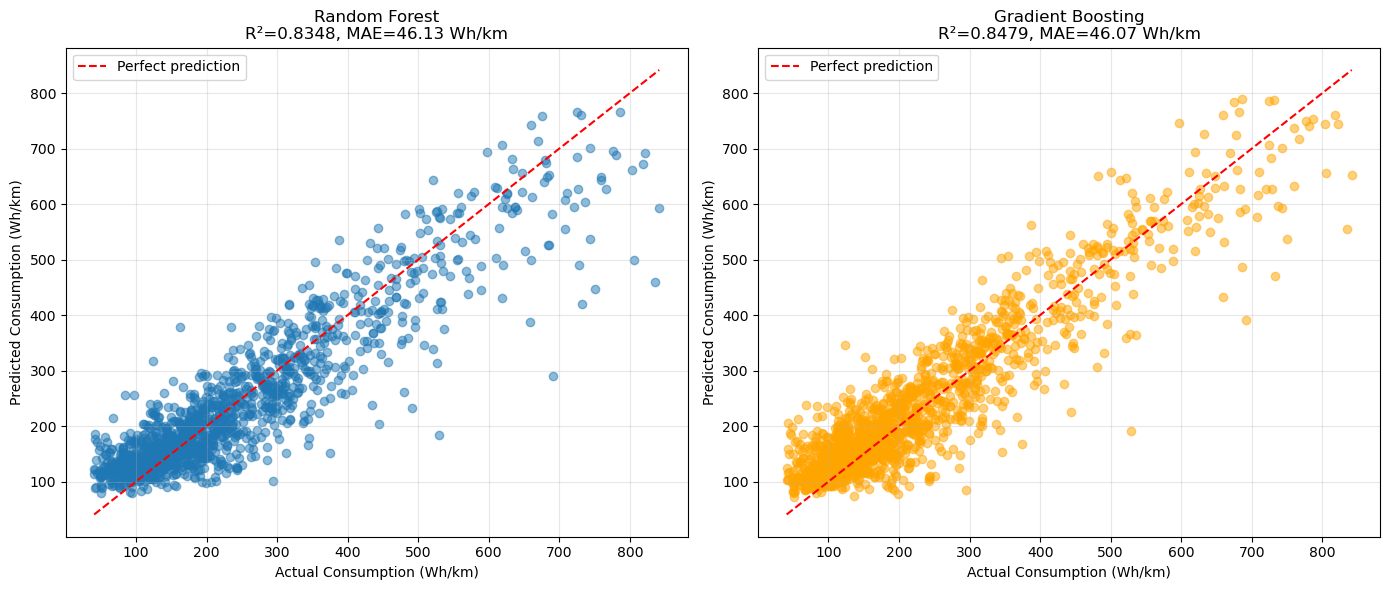

In [25]:
test_predictions_rf = []
test_predictions_gb = []

for trip in test_trips[:5]:
    trip_data = test_data[test_data['Trip'] == trip].copy()
    
    for idx, row in trip_data.iterrows():
        conditions = row[feature_cols].to_dict()
        current_soc = row['SOC_start']
        actual_consumption = row['Energy_Consumption_Wh_per_km']
        
        _, _, pred_consumption_rf = estimate_range(current_soc, conditions, model=rf_model)
        _, _, pred_consumption_gb = estimate_range(current_soc, conditions, model=gb_model)
        
        test_predictions_rf.append({
            'Trip': trip,
            'SOC': current_soc,
            'Predicted_Consumption': pred_consumption_rf,
            'Actual_Consumption': actual_consumption
        })
        
        test_predictions_gb.append({
            'Trip': trip,
            'SOC': current_soc,
            'Predicted_Consumption': pred_consumption_gb,
            'Actual_Consumption': actual_consumption
        })

test_pred_rf_df = pd.DataFrame(test_predictions_rf)
test_pred_gb_df = pd.DataFrame(test_predictions_gb)

print("\n=== Test Trip Validation ===")
print(f"Total test segments: {len(test_pred_rf_df)}")

rf_val_mae = mean_absolute_error(test_pred_rf_df['Actual_Consumption'], test_pred_rf_df['Predicted_Consumption'])
rf_val_r2 = r2_score(test_pred_rf_df['Actual_Consumption'], test_pred_rf_df['Predicted_Consumption'])

gb_val_mae = mean_absolute_error(test_pred_gb_df['Actual_Consumption'], test_pred_gb_df['Predicted_Consumption'])
gb_val_r2 = r2_score(test_pred_gb_df['Actual_Consumption'], test_pred_gb_df['Predicted_Consumption'])

print(f"\nRandom Forest:")
print(f"  MAE: {rf_val_mae:.2f} Wh/km")
print(f"  R²: {rf_val_r2:.4f}")

print(f"\nGradient Boosting:")
print(f"  MAE: {gb_val_mae:.2f} Wh/km")
print(f"  R²: {gb_val_r2:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(test_pred_rf_df['Actual_Consumption'], test_pred_rf_df['Predicted_Consumption'], alpha=0.5)
axes[0].plot([test_pred_rf_df['Actual_Consumption'].min(), test_pred_rf_df['Actual_Consumption'].max()],
         [test_pred_rf_df['Actual_Consumption'].min(), test_pred_rf_df['Actual_Consumption'].max()],
         'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Consumption (Wh/km)')
axes[0].set_ylabel('Predicted Consumption (Wh/km)')
axes[0].set_title(f'Random Forest\nR²={rf_val_r2:.4f}, MAE={rf_val_mae:.2f} Wh/km')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(test_pred_gb_df['Actual_Consumption'], test_pred_gb_df['Predicted_Consumption'], alpha=0.5, color='orange')
axes[1].plot([test_pred_gb_df['Actual_Consumption'].min(), test_pred_gb_df['Actual_Consumption'].max()],
         [test_pred_gb_df['Actual_Consumption'].min(), test_pred_gb_df['Actual_Consumption'].max()],
         'r--', label='Perfect prediction')
axes[1].set_xlabel('Actual Consumption (Wh/km)')
axes[1].set_ylabel('Predicted Consumption (Wh/km)')
axes[1].set_title(f'Gradient Boosting\nR²={gb_val_r2:.4f}, MAE={gb_val_mae:.2f} Wh/km')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)

gb_test_r2 = r2_score(y_test, y_test_pred_gb)
gb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
gb_test_mae = mean_absolute_error(y_test, y_test_pred_gb)

print("="*70)
print("RANGE PREDICTION MODEL SUMMARY")
print("="*70)
print(f"\nDataset: {len(data):,} segments from {len(valid_trips)} trips")
print(f"Features: {len(feature_cols)}")

print("\n--- Model Comparison ---")
print(f"\nRandom Forest:")
print(f"  R²: {rf_test_r2:.4f}")
print(f"  RMSE: {rf_test_rmse:.2f} Wh/km")
print(f"  MAE: {rf_test_mae:.2f} Wh/km")

print(f"\nGradient Boosting:")
print(f"  R²: {gb_test_r2:.4f}")
print(f"  RMSE: {gb_test_rmse:.2f} Wh/km")
print(f"  MAE: {gb_test_mae:.2f} Wh/km")

best_model_name = 'Gradient Boosting' if gb_test_r2 > rf_test_r2 else 'Random Forest'
best_model = gb_model if gb_test_r2 > rf_test_r2 else rf_model

print(f"\nRecommended Model: {best_model_name}")

best_importance_col = 'GB_Importance' if gb_test_r2 > rf_test_r2 else 'RF_Importance'
top_features = feature_importance.sort_values(best_importance_col, ascending=False).head(3)

print(f"\nTop 3 Features:")
for i, row in top_features.iterrows():
    print(f"  {row['Feature']}: {row[best_importance_col]:.3f}")

print("\n--- Usage ---")
print(f"Use estimate_range(soc, conditions, model={best_model_name.lower().replace(' ', '_')}_model)")
print("="*70)

RANGE PREDICTION MODEL SUMMARY

Dataset: 10,624 segments from 39 trips
Features: 13

--- Model Comparison ---

Random Forest:
  R²: 0.8255
  RMSE: 61.48 Wh/km
  MAE: 44.47 Wh/km

Gradient Boosting:
  R²: 0.8355
  RMSE: 59.69 Wh/km
  MAE: 44.80 Wh/km

Recommended Model: Gradient Boosting

Top 3 Features:
  Velocity_std: 0.516
  Acceleration: 0.272
  Velocity_avg: 0.064

--- Usage ---
Use estimate_range(soc, conditions, model=gradient_boosting_model)
